In [1]:
import gc
import os

import pandas as pd

import torch
import numpy as np
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.model_selection import train_test_split
from torch.nn.functional import normalize
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import uci_dataset as dataset

In [2]:
def to_torch(X, d_type: torch.dtype):
    m, n = X.shape[0], X.shape[1]
    X_inner = torch.tensor(X, dtype=d_type)

    X_prime = normalize(torch.cat(
        [X_inner, torch.ones(m, dtype=d_type).reshape(-1, 1)], dim=1
    ), p=2, dim=1)
    return X_prime

In [3]:
def kronecker(a: torch.Tensor, b: torch.Tensor):
    return torch.einsum('na,nb->nab', a, b).view(a.size(0), a.size(1) * b.size(1))

In [4]:
if not os.path.exists('./iris_output'):
        os.mkdir('./iris_output')

In [7]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64

    X, y = load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)
    X_prime = to_torch(X_train, d_type=d_type)

    test_class = 0
    test_no = 1
    X_test_prime = to_torch(X_test[y_test == test_class], d_type=d_type)

    max_copies = 300
    result = []
    for copies in range(1, max_copies + 1):
        c = X_test_prime[test_class]
        result_sum = 0
        result_sum_fid = 0
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum += result_ab
                result_sum_fid += result_ab_fid
                
    
        result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
        result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            
        df_copies = pd.DataFrame(
            data=[[copies, result_sum, result_sum_fid]],
            columns=['Copies', 'Helstrom sim', 'Fidelity sim']
        )
        result.append(df_copies)
        df = pd.concat(result)

df.to_csv(f'./iris_output/iris_score_copies_{max_copies}.csv')   

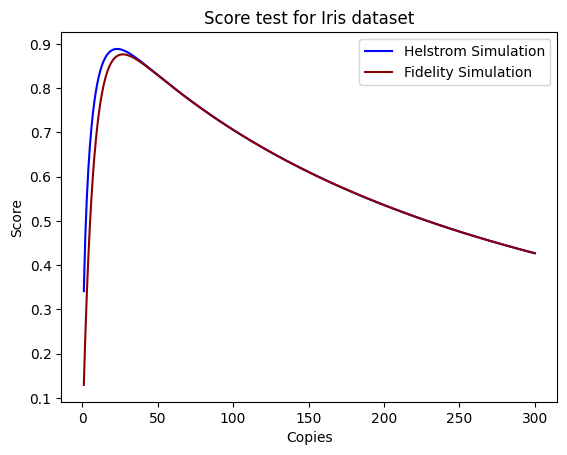

In [9]:
df = pd.read_csv(f'./iris_output/iris_score_copies_{max_copies}.csv')
fig: Figure = plt.figure()
ax: Axes = fig.subplots()
df.plot(x='Copies', y='Helstrom sim', kind='line', ax=ax, label='Helstrom Simulation', color='blue')
df.plot(x='Copies', y='Fidelity sim', kind='line', ax=ax, label='Fidelity Simulation', color='darkred')
ax.set_ylabel('Score')
plt.legend()
plt.title("Score test for Iris dataset")
plt.savefig(f'./iris_output/score_test_{test_class}_{max_copies}.png')
plt.savefig(f'./iris_output/score_test_{test_class}_{max_copies}.pdf')
plt.show()

In [10]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64

    X, y = load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)
    X_prime = to_torch(X_train, d_type=d_type)

    test_class = 0
    test_no = 1
    X_test_prime = to_torch(X_test, d_type=d_type)


    max_copies = 100
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    accuracy = torch.zeros(max_copies)
    accuracy_fid = torch.zeros(max_copies)
    
    for copies in range(1,max_copies+1):
        for i in range(X_test_prime.shape[0]):
            c = X_test_prime[i] 
            for a_index in range(X_prime[y_train == 0].shape[0]):
                for b_index in range(X_prime[y_train == 1].shape[0]):
                    a = X_prime[y_train == 0][a_index]
                    b = X_prime[y_train == 1][b_index]

                    inner_product_ab: torch.Tensor = torch.matmul(a, b)
                    inner_product_ca: torch.Tensor = torch.matmul(c, a)
                    inner_product_cb: torch.Tensor = torch.matmul(c, b)
                    overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                    overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                    overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                    lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                    contrib_ca = np.power(overlap_ca, copies)
                    contrib_cb = np.power(overlap_cb, copies)
    
                    result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                    result_ab_fid = contrib_ca - contrib_cb
                    result_sum[i] += result_ab
                    result_sum_fid[i] += result_ab_fid
            
            result_sum[i] = result_sum[i] / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            result_sum_fid[i] = result_sum_fid[i] / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            
            
            if result_sum[i] > 0:
                result_sum[i] = 0
            else:
                result_sum[i] = 1
            
            if result_sum_fid[i] > 0:
                result_sum_fid[i] = 0
            else:
                result_sum_fid[i] = 1
    
        
        accuracy[copies-1] = metrics.accuracy_score(y_test, result_sum, normalize=True, sample_weight=None)
        accuracy_fid[copies-1] = metrics.accuracy_score(y_test, result_sum_fid, normalize=True, sample_weight=None) 

In [11]:
copies = torch.zeros(max_copies)
for i in range(max_copies):
    copies[i] = i+1

d = {'copies' : copies, 'accuracy' : accuracy, 'accuracy_fid': accuracy_fid}
df = pd.DataFrame(data = d)
df.to_csv(f'./iris_output/iris_accuracy_copies_{max_copies}.csv')   


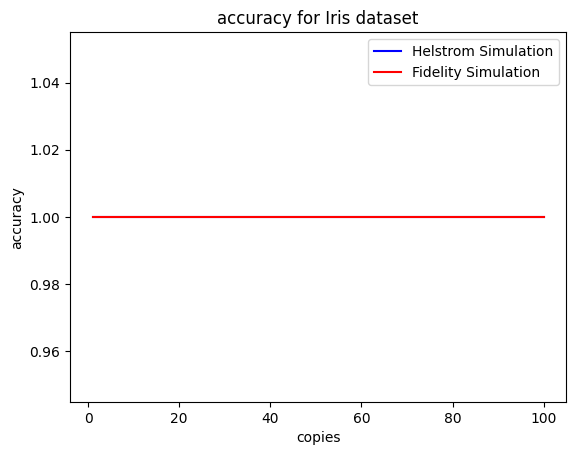

In [13]:
df = pd.read_csv(f'./iris_output/iris_accuracy_copies_{max_copies}.csv')
fig: Figure = plt.figure()
ax: Axes = fig.subplots()
df.plot(x='copies', y='accuracy', kind='line', ax=ax, label='Helstrom Simulation', color='blue')
df.plot(x='copies', y='accuracy', kind='line', ax=ax, label='Fidelity Simulation', color='red')
ax.set_ylabel('accuracy')
plt.legend()
plt.title("accuracy for Iris dataset")
plt.savefig(f'./iris_output/iris_accuracy_test_{max_copies}.png')
plt.savefig(f'./iris_output/iris_accuracy_test_{max_copies}.pdf')
plt.show()

In [14]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64


    X, y = load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)
    X_prime = to_torch(X_train, d_type=d_type)


    test_no = 10
    X_test_prime = to_torch(X_test, d_type=d_type)

    copies = 10
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    
    for i in range(X_test_prime.shape[0]):
        c = X_test_prime[i] 
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum[i] += result_ab
                result_sum_fid[i] += result_ab_fid
                
    
result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])

In [15]:
df_2 = pd.DataFrame(np.asarray([
            result_sum.numpy().T,
            result_sum_fid.numpy(),
            y_test
        ]).T, columns=['result_sum', 'result_sum_fid', 'y_test'])
df_2.to_csv(f'./iris_output/iris_classification_test_copies_{copies}.csv')

In [16]:
def classifier(y_pred, t):
    y_prime = torch.zeros(y_pred.shape[0])
    for i in range (y_pred.shape[0]):
        if y_pred[i] > t:
            y_prime[i] = 0
        else:
            y_prime[i] = 1
    return y_prime

In [18]:
copies = 10
df = pd.read_csv(f'./iris_output/iris_classification_test_copies_{copies}.csv')
result_sum10 = df['result_sum']
result_sum_fid10 = df['result_sum_fid']
t = -2

result_sort = result_sum10.sort_values()
tpr = torch.zeros(result_sort.shape[0])
fpr = torch.zeros(result_sort.shape[0])

for i in range(result_sort.shape[0]):
    result_sort = result_sum10.sort_values()
    if t != result_sort[i]:
        t = result_sort[i]
        
    hel_pred = classifier(result_sum10, t)
    
    tn, fp, fn, tp = confusion_matrix(y_test, hel_pred).ravel()
    
    tpr[i] = tp / (tp+fn)
    fpr[i] = fp / (tp+fn)

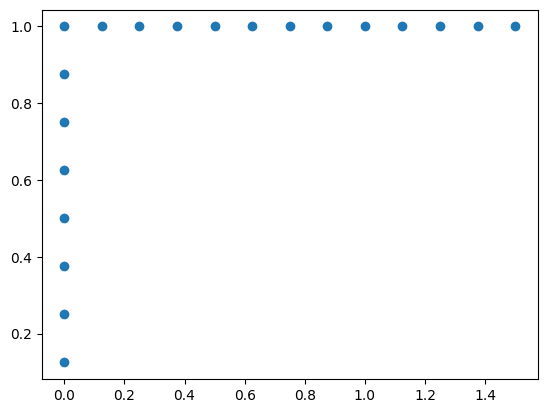

In [19]:
plt.scatter(fpr, tpr)